In [30]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

In [31]:
dataset_name = 'horses_or_humans'
train_ds , valid_ds , test_ds = tfds.load(dataset_name , split = ['train[:70%]' , 'train[70%:80%]' , 'train[80%:]'] , as_supervised = True )

In [32]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [33]:
dataset_name = 'horses_or_humans'
data_builder = tfds.builder(dataset_name)
data_info = data_builder.info
class_labels = data_info.features['label'].names
classes = {label_idx : class_label for label_idx , class_label in enumerate(class_labels)}

In [34]:
classes

{0: 'horses', 1: 'humans'}

In [35]:
total_class = 2

Text(0.5, 1.0, 'horses')

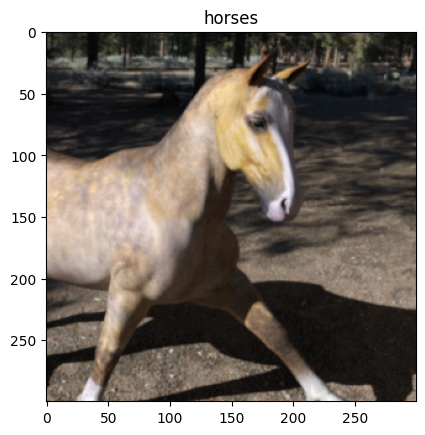

In [36]:
plt.imshow(next(iter(train_ds))[0].numpy())

plt.title(classes[next(iter(train_ds))[1].numpy()])

In [37]:
def preprocess_images(image, label):
    image = tf.image.resize(image , (224,224)) # Resize
    image = image / 255 # Scale
    return image , label

In [38]:
len(train_ds)

719

In [41]:
pp_train_ds = train_ds.shuffle(len(train_ds)).batch(64).map(preprocess_images).prefetch(tf.data.AUTOTUNE)
pp_valid_ds = valid_ds.shuffle(len(valid_ds)).batch(64).map(preprocess_images).prefetch(tf.data.AUTOTUNE)
pp_test_ds = test_ds.shuffle(len(test_ds)).batch(64).map(preprocess_images).prefetch(tf.data.AUTOTUNE)

In [42]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense , Flatten , Dropout , InputLayer
from tensorflow.keras.layers import Conv2D , MaxPooling2D , GlobalMaxPool2D

In [ ]:
basic_cnn_model = Sequential([
    InputLayer((224,224,3)),

    Conv2D(16 , 3 , padding = 'same' , activation = 'relu'),
    MaxPooling2D((3,3)),

    Conv2D(16 , 3 , padding = 'same' , activation = 'relu'),
    MaxPooling2D((3,3)),

    Flatten(),

    Dense(64 , activation = 'relu'),

    Dense(total_class , activation = 'softmax')
])

basic_cnn_model.summary()

In [44]:
basic_cnn_model.compile(loss = 'sparse_categorical_crossentropy' , optimizer = 'adam' , metrics = ['acc'] )

basic_cnn_model.fit(pp_train_ds , epochs = 10 , validation_data = pp_valid_ds )

Epoch 1/10
12/12 [==============================] - 5s 115ms/step - loss: 0.8716 - acc: 0.5438 - val_loss: 0.6579 - val_acc: 0.5825
Epoch 2/10
12/12 [==============================] - 1s 61ms/step - loss: 0.6584 - acc: 0.7065 - val_loss: 0.6063 - val_acc: 0.6311
Epoch 3/10
12/12 [==============================] - 1s 62ms/step - loss: 0.5552 - acc: 0.7636 - val_loss: 0.4056 - val_acc: 0.9417
Epoch 4/10
12/12 [==============================] - 1s 58ms/step - loss: 0.3124 - acc: 0.9249 - val_loss: 0.2092 - val_acc: 0.9417
Epoch 5/10
12/12 [==============================] - 1s 63ms/step - loss: 0.1622 - acc: 0.9499 - val_loss: 0.1070 - val_acc: 0.9709
Epoch 6/10
12/12 [==============================] - 1s 57ms/step - loss: 0.1043 - acc: 0.9694 - val_loss: 0.1248 - val_acc: 0.9515
Epoch 7/10
12/12 [==============================] - 1s 71ms/step - loss: 0.0801 - acc: 0.9722 - val_loss: 0.0920 - val_acc: 0.9612
Epoch 8/10
12/12 [==============================] - 1s 95ms/step - loss: 0.0620 - 

#TL


In [45]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [46]:
def resize_images(image, label):
    image = tf.image.resize(image, [224, 224])

    return image / 255, label

train_ds_resized = train_ds.shuffle(500).batch(64).map(resize_images).prefetch(tf.data.AUTOTUNE)
valid_ds_resized = valid_ds.shuffle(500).batch(64).map(resize_images).prefetch(tf.data.AUTOTUNE)
test_ds_resized = test_ds.shuffle(500).batch(64).map(resize_images).prefetch(tf.data.AUTOTUNE)

In [47]:
train_ds_resized

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [48]:
input_layer = tf.keras.Input((224, 224, 3))

In [49]:
input_layer

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_4')>

In [50]:
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=input_layer,
)

94765736/94765736 [==============================] - 1s 0us/step


In [51]:
base_model.output

<KerasTensor: shape=(None, 7, 7, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [52]:
global_pooling = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

x = tf.keras.layers.Dense(64, activation = "relu")(global_pooling)
x = tf.keras.layers.Dropout(0.2)(x) # Parantez (x) unutulursa --> Graph disconnected hatası verir.
outputs = tf.keras.layers.Dense(total_class, activation = "softmax")(x) #output_layer da olabilirdi.


In [53]:
tl_model = tf.keras.Model(input_layer, outputs)
tl_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [55]:
tl_model.compile(optimizer = "adam", 
                 loss = "sparse_categorical_crossentropy",
                 metrics = ["acc"])

In [56]:
tl_model.fit(train_ds_resized, epochs = 10, validation_data = valid_ds_resized)

Epoch 1/10
12/12 [==============================] - 55s 1s/step - loss: 0.1128 - acc: 0.9402 - val_loss: 647.2596 - val_acc: 0.4175
Epoch 2/10
12/12 [==============================] - 7s 563ms/step - loss: 0.0493 - acc: 0.9861 - val_loss: 37342.8398 - val_acc: 0.5825
Epoch 3/10
12/12 [==============================] - 7s 572ms/step - loss: 0.0454 - acc: 0.9861 - val_loss: 16363.1846 - val_acc: 0.5825
Epoch 4/10
12/12 [==============================] - 7s 591ms/step - loss: 0.0540 - acc: 0.9889 - val_loss: 3216.2373 - val_acc: 0.5825
Epoch 5/10
12/12 [==============================] - 7s 598ms/step - loss: 0.0890 - acc: 0.9764 - val_loss: 4379.4023 - val_acc: 0.4175
Epoch 6/10
12/12 [==============================] - 7s 573ms/step - loss: 0.0120 - acc: 0.9986 - val_loss: 1.4697 - val_acc: 0.5825
Epoch 7/10
12/12 [==============================] - 7s 594ms/step - loss: 0.0224 - acc: 0.9917 - val_loss: 402.1487 - val_acc: 0.4175
Epoch 8/10
12/12 [==============================] - 7s 597ms